In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as plotly
from pandas_profiling import ProfileReport

In [2]:
os.chdir('x:\\Academico\\CUNEF\\TFM\\predictive_maintenance')

In [3]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

original_data_path = 'src\\data\\raw'

In [4]:
train = pd.read_csv(original_data_path+'\\'+'train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv(original_data_path+'\\'+'test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((original_data_path+'\\'+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [12]:
print(train.shape, test.shape, y_test.shape)

(20631, 26) (13096, 26) (100, 1)


In [5]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
sensor_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sensor_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
sensor_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


In [6]:
df_max_rul = train[['engine', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

KeyError: "['RUL'] not in index"

In [13]:
test_df= test.groupby('engine').agg({'cycle':'max'})
y_test['cycle'] = test_df['cycle']

In [14]:
cycle=[]
for i in range(len(y_test)):
    try:
        cycle.append(y_test['RUL'][i] + y_test['cycle'][i+1])
    except:
        cycle.append(198+20)
        
test_df['cycle']= cycle

In [15]:
train_df= train.groupby('engine').agg({'cycle':'max'})

In [16]:
def add_remaining_useful_life(df, max_df):
    # Get the total number of cycles for each unit
    max_cycle= max_df['cycle']
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train,train_df)
test=add_remaining_useful_life(test,test_df)
test[index_names+['RUL']].head()

,engine,cycle,RUL
0,1,1,142.0
1,1,2,141.0
2,1,3,140.0
3,1,4,139.0
4,1,5,138.0


In [17]:
train_report = ProfileReport(train_df, title='Training Dataset EDA Report')
train_report.to_file('reports/train_eda_report.html')
train_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
test_report = ProfileReport(test_df, title='Testing Dataset EDA Report')
test_report.to_file('reports/test_eda_report.html')
test_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [21]:
train = pd.read_csv(original_data_path+'\\'+'train_FD001.txt', sep=' ', header=None, names=columns)
test = pd.read_csv(original_data_path+'\\'+'test_FD001.txt', sep=' ', header=None, names=columns)
y_test = pd.read_csv((original_data_path+'\\'+'RUL_FD001.txt'), sep=' ', header=None)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   op1       20631 non-null  float64
 3   op2       20631 non-null  float64
 4   op3       20631 non-null  float64
 5   sensor1   20631 non-null  float64
 6   sensor2   20631 non-null  float64
 7   sensor3   20631 non-null  float64
 8   sensor4   20631 non-null  float64
 9   sensor5   20631 non-null  float64
 10  sensor6   20631 non-null  float64
 11  sensor7   20631 non-null  float64
 12  sensor8   20631 non-null  float64
 13  sensor9   20631 non-null  float64
 14  sensor10  20631 non-null  float64
 15  sensor11  20631 non-null  float64
 16  sensor12  20631 non-null  float64
 17  sensor13  20631 non-null  float64
 18  sensor14  20631 non-null  float64
 19  sensor15  20631 non-null  float64
 20  sensor16  20631 non-null  fl

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   op1       13096 non-null  float64
 3   op2       13096 non-null  float64
 4   op3       13096 non-null  float64
 5   sensor1   13096 non-null  float64
 6   sensor2   13096 non-null  float64
 7   sensor3   13096 non-null  float64
 8   sensor4   13096 non-null  float64
 9   sensor5   13096 non-null  float64
 10  sensor6   13096 non-null  float64
 11  sensor7   13096 non-null  float64
 12  sensor8   13096 non-null  float64
 13  sensor9   13096 non-null  float64
 14  sensor10  13096 non-null  float64
 15  sensor11  13096 non-null  float64
 16  sensor12  13096 non-null  float64
 17  sensor13  13096 non-null  float64
 18  sensor14  13096 non-null  float64
 19  sensor15  13096 non-null  float64
 20  sensor16  13096 non-null  fl

In [24]:
y_test.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


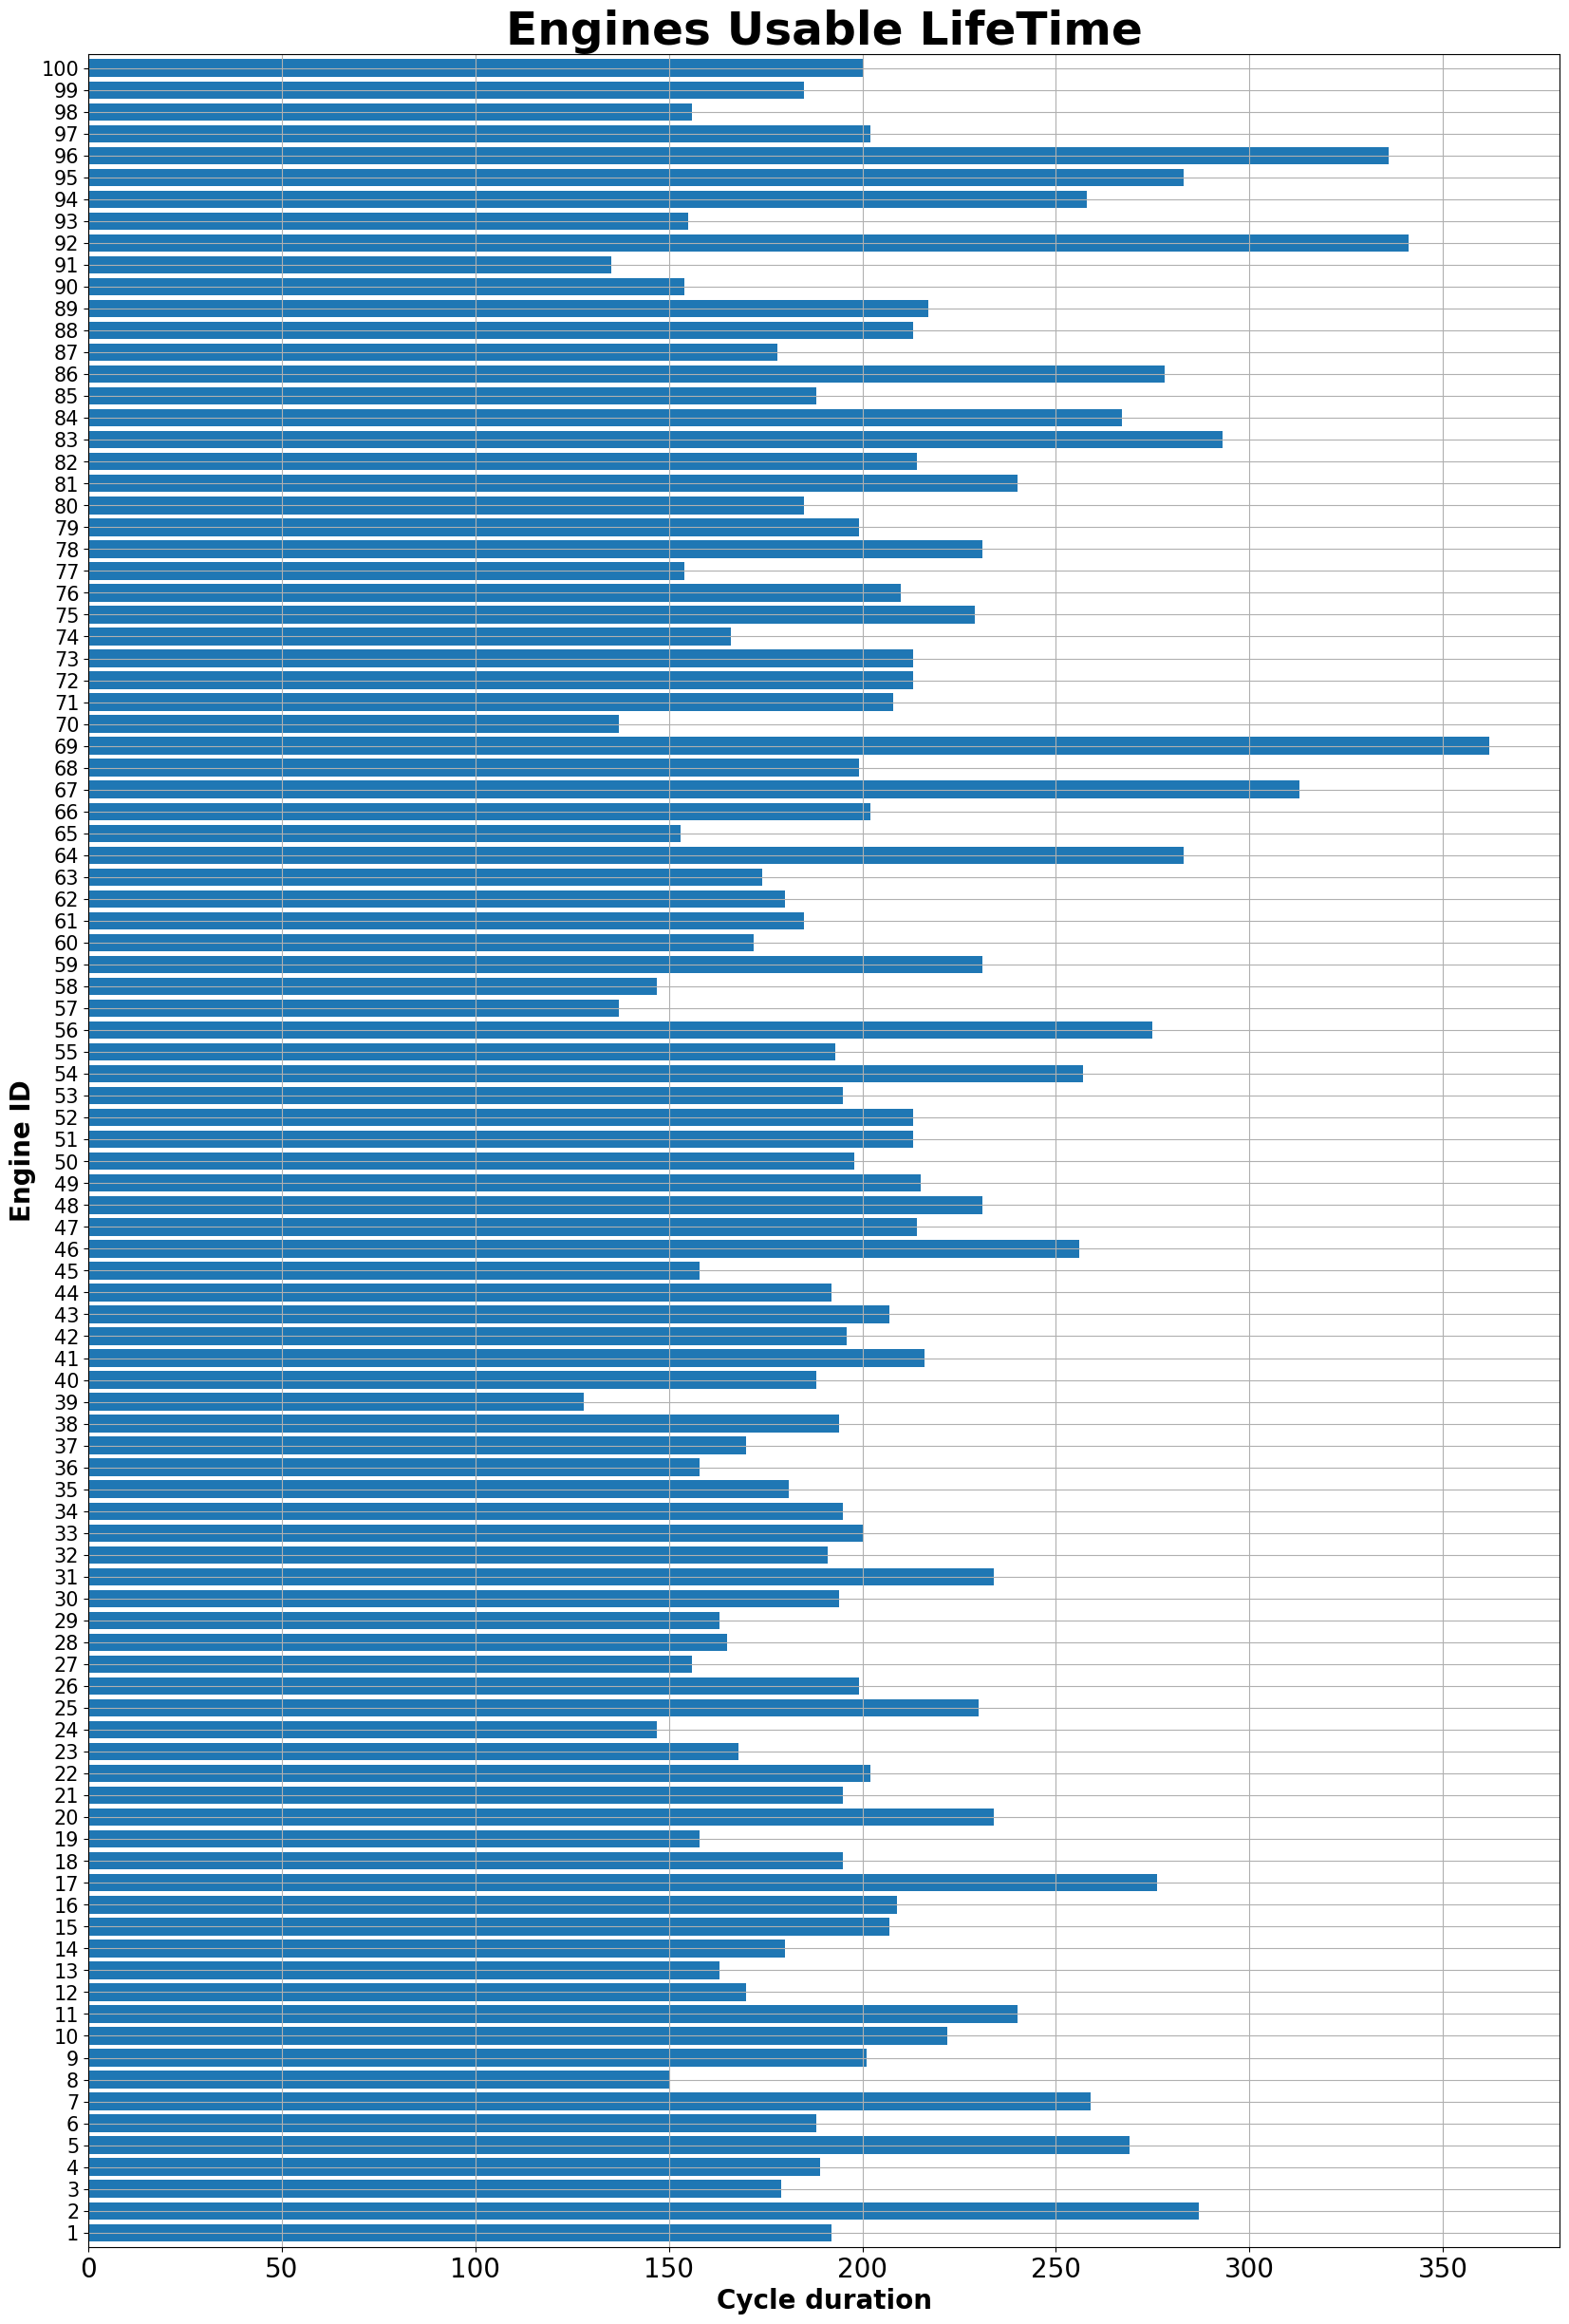

In [25]:
plt.figure(figsize=(20,30))
ax=train.groupby('id')['cycle'].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
plt.title('Engines Usable LifeTime',fontweight='bold',size=35)
plt.xlabel('Cycle duration',fontweight='bold',size=20)
plt.xticks(size=20)
plt.ylabel('Engine ID',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid()
plt.show()

In [26]:
df = pd.concat([train,test])

In [27]:
sensor_list = []
for column in df.columns:
    if 'sensor' in column:
        sensor_list.append(column)

In [29]:
df.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


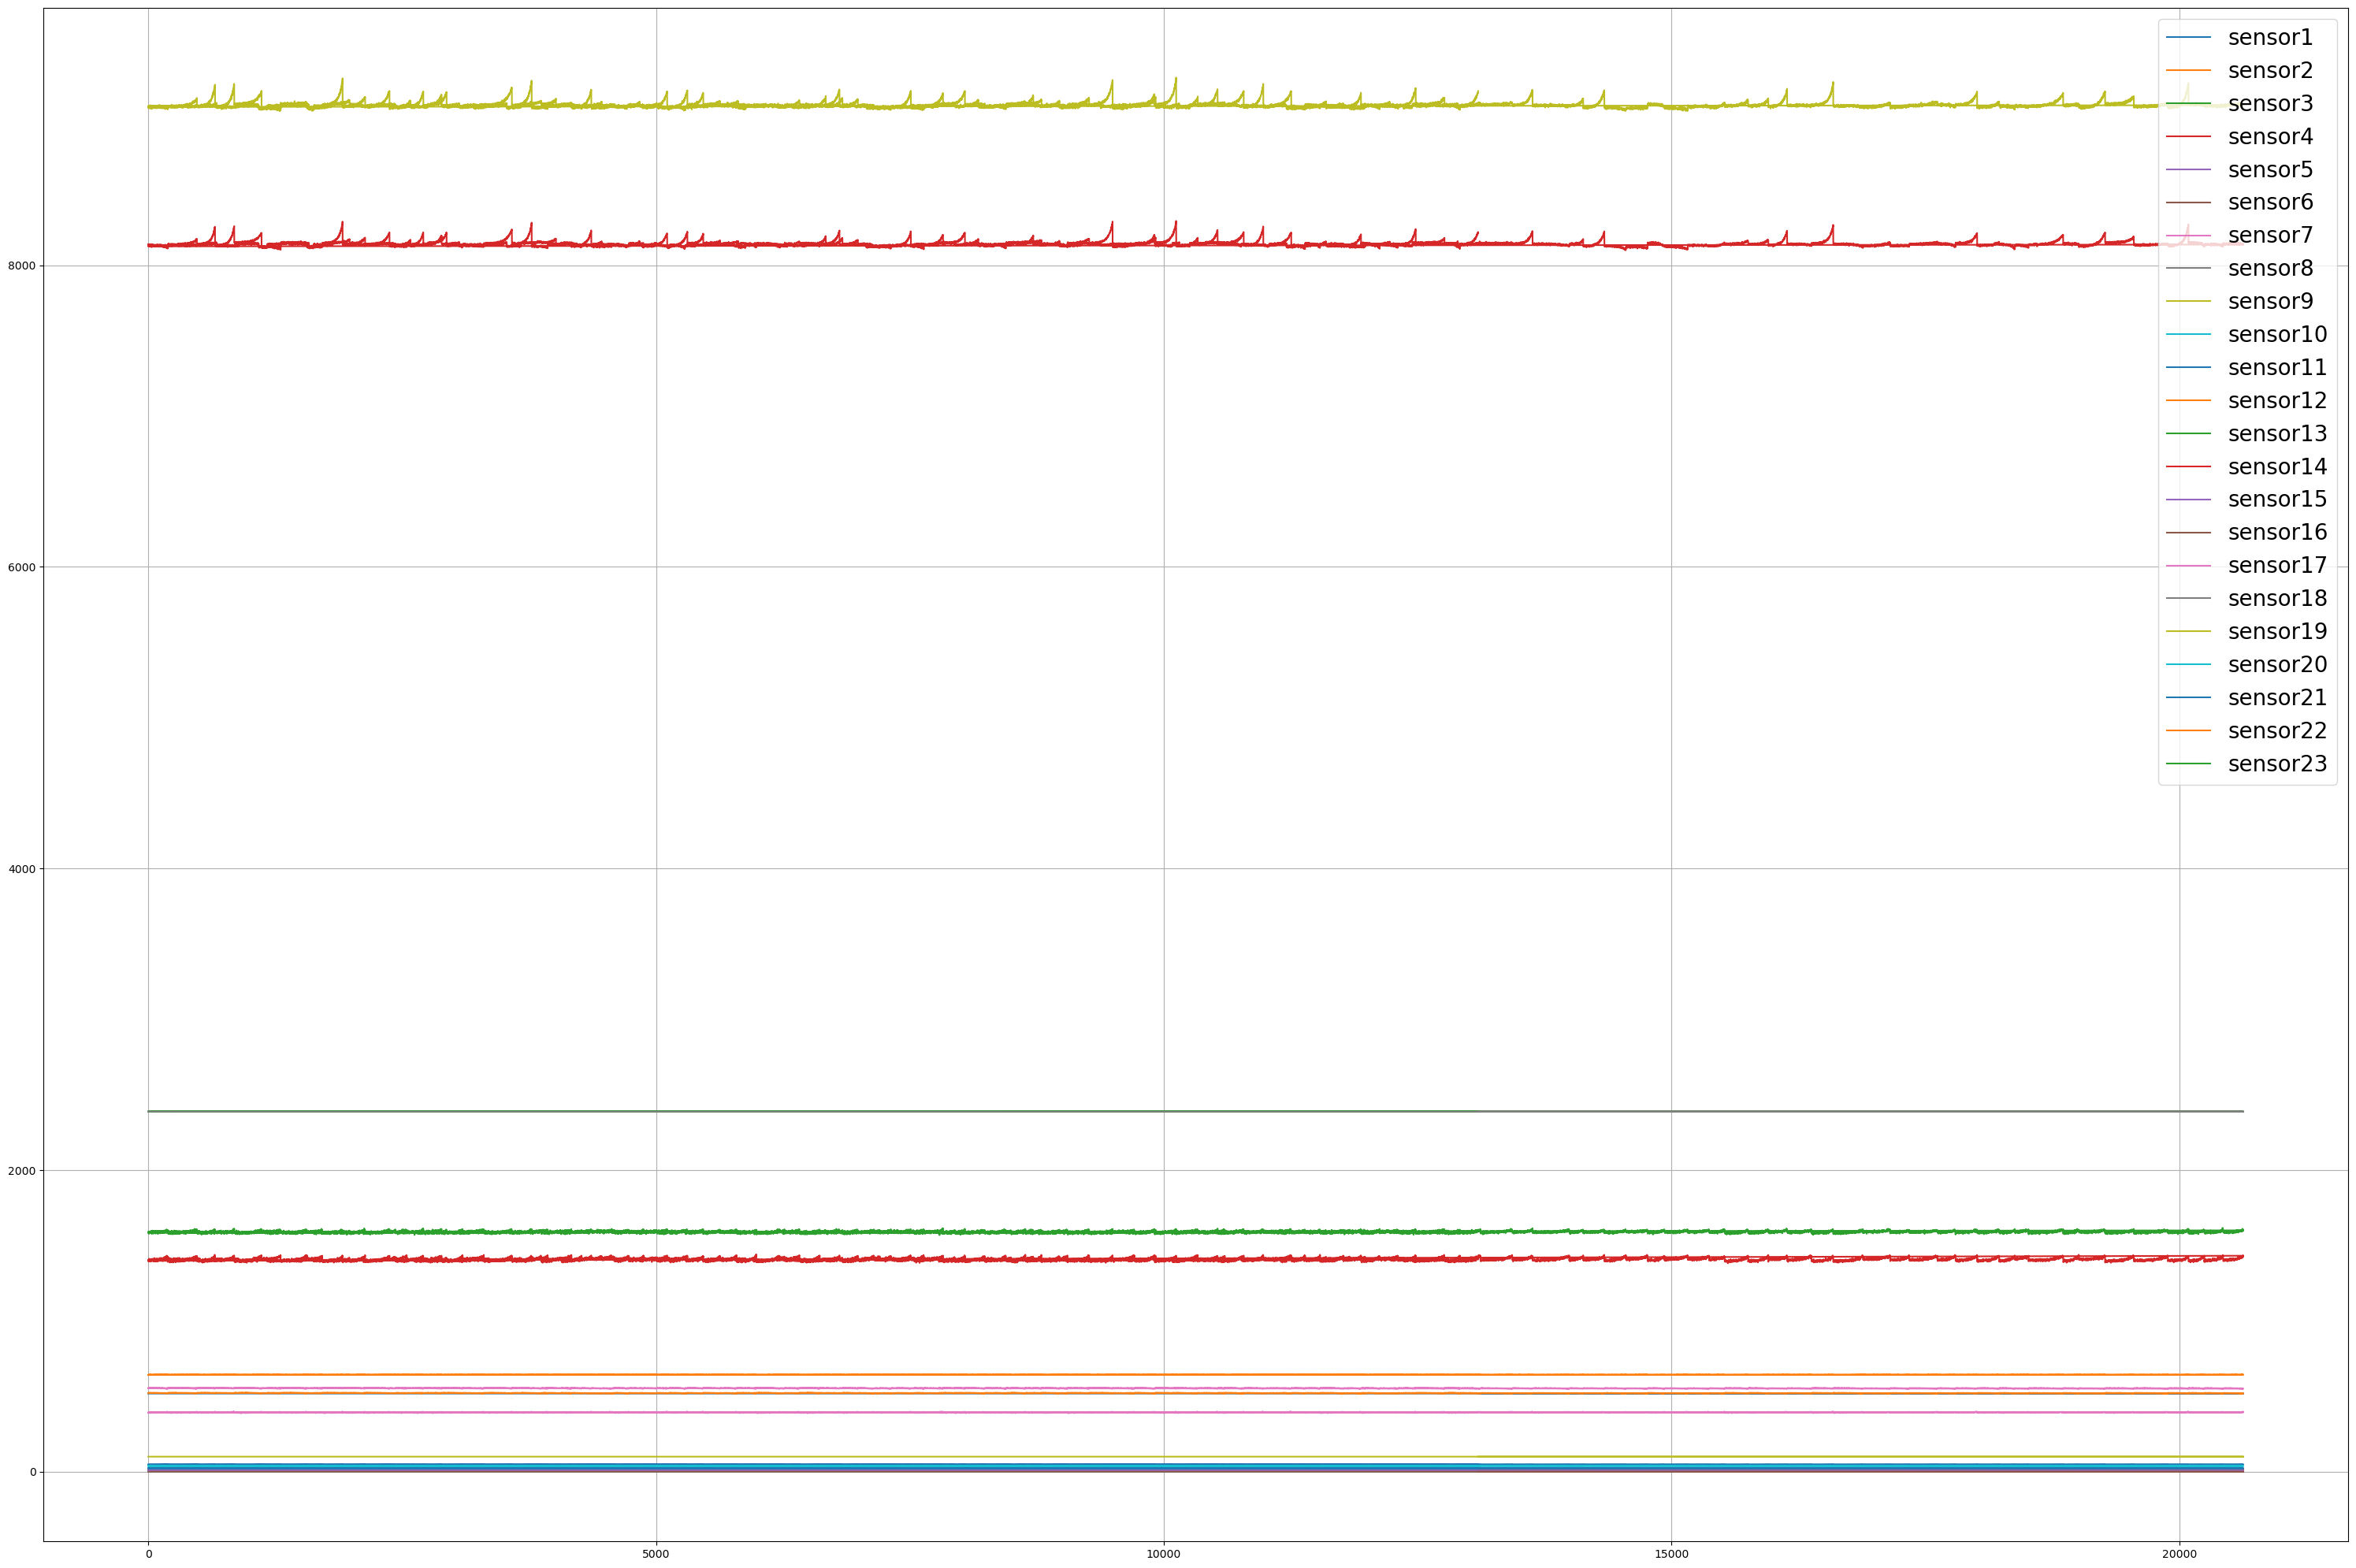

In [28]:
plt.rcParams["figure.figsize"] = [30, 20]
plt.rcParams["figure.autolayout"] = True

for sensor in sensor_list:
    df[sensor].plot(grid=True, label=str(sensor), legend=True).legend(prop={'size': 20})